## <b>1 <span style='color:#2ae4f5'>|</span> Bibliotecas e Imports</b>

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorEstimator
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Statevector
import math
import json
# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
import matplotlib.pyplot as plt

from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    phase_amplitude_damping_error,
    phase_damping_error,
    amplitude_damping_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
with open('apiKey.json') as f:
    data = json.load(f)
    token = data['apikey']

#QiskitRuntimeService.save_account(
#token=token,
#)
service = QiskitRuntimeService()

qiskit_runtime_service.__init__:WARNING:2025-11-20 15:22:15,596: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: Projeto-Algo_I. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


## <b>2 <span style='color:#2ae4f5'>|</span> Funções Auxiliares </b>

In [37]:
def create_grover_oracle(target_state):

    num_qubits = len(target_state)
    oracle = QuantumCircuit(num_qubits, name=f"oracle_{target_state}")

    target_state = target_state[::-1]

    for i, bit in enumerate(target_state):
        if bit == '0':
            oracle.x(i)

    # Como Qiskit não tem CCZ nativo para n>2, podemos usar uma equivalencia logica a partir de  H-control-NOT-H para qubit alvo
    oracle.h(num_qubits-1)
    oracle.mcx(list(range(num_qubits-1)), num_qubits-1)
    oracle.h(num_qubits-1)

    for i, bit in enumerate(target_state):
        if bit == '0':
            oracle.x(i)

    return oracle

def plot_counts_matplotlib(counts, target):
    plt.figure(figsize=(8, 5))
    # Ordena as labels
    labels = list(counts.keys())
    values = [counts[k] for k in labels]
    plt.bar(labels, values)
    plt.title(f"Histograma para target {target}")
    plt.xlabel('Estado')
    plt.ylabel('Frequência')
    plt.savefig(f'histograma_target_{target}.png')
    plt.show()
    plt.clf()

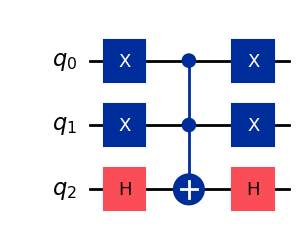

In [38]:
qc = create_grover_oracle("100")

qc.draw('mpl')

## <b>3 <span style='color:#2ae4f5'>|</span> Grover Ideal </b>

### Implementação Detalhada

In [39]:
num_qubits = 3


qc = QuantumCircuit(num_qubits, num_qubits)

In [40]:
iterations = math.ceil((math.pi / 4) * math.sqrt(num_qubits))
print(iterations)

2


Definimos o operador de difusão

In [41]:
def difusion(num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    qc.x(range(num_qubits))
    qc.h(2)
    qc.ccx(0,1,2)
    qc.h(2)
    qc.x(range(num_qubits))
    qc.h(range(num_qubits))

    qc.draw('mpl')
    return qc

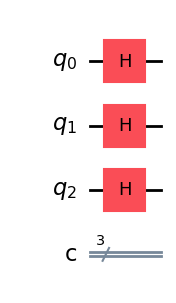

In [42]:
qc.h(range(num_qubits))

qc.draw('mpl')

In [43]:
for _ in range(iterations):
    
    qc.compose(create_grover_oracle("101"),inplace=True)

    qc.compose(difusion(num_qubits),inplace=True)

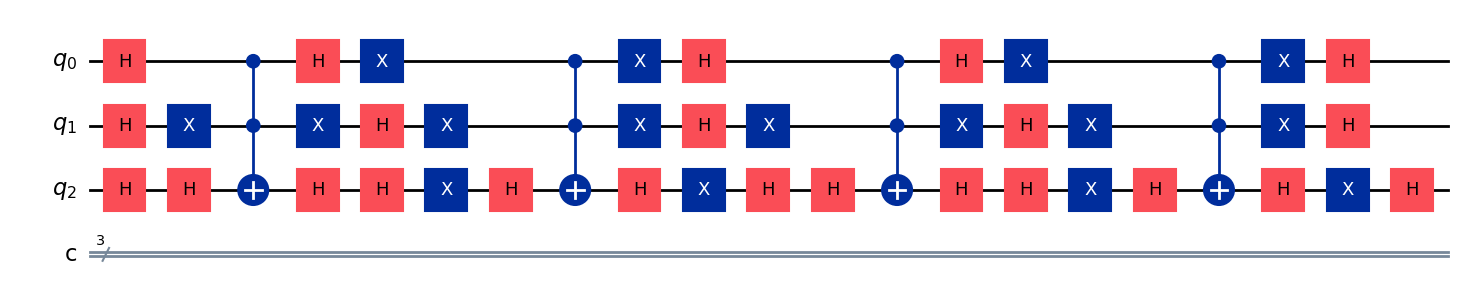

In [44]:
qc.draw('mpl')

Resultados: {'001': 6, '110': 3, '100': 8, '011': 12, '111': 6, '000': 4, '010': 8, '101': 977}


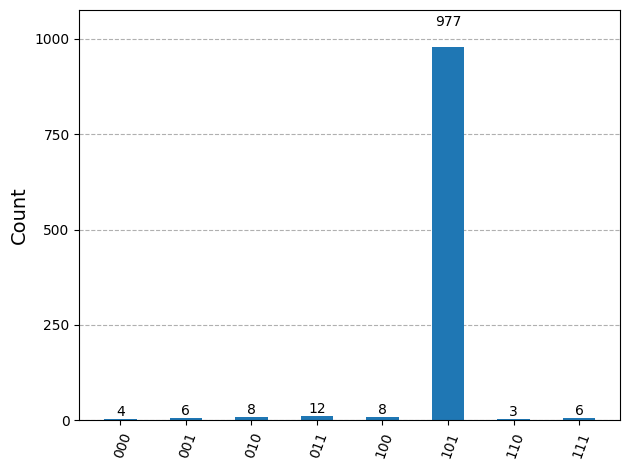

In [45]:
qc.measure(range(num_qubits), range(num_qubits))

backend = AerSimulator()
t_qc = transpile(qc, backend)
result = backend.run(t_qc, shots=1024).result()
counts = result.get_counts()

print("Resultados:", counts)
plot_histogram(counts)

### Rodadas de testes para N oraculos/alvos diferentes:

2
Resultados: {'101': 5, '011': 11, '111': 14, '010': 8, '000': 7, '110': 8, '001': 10, '100': 961}


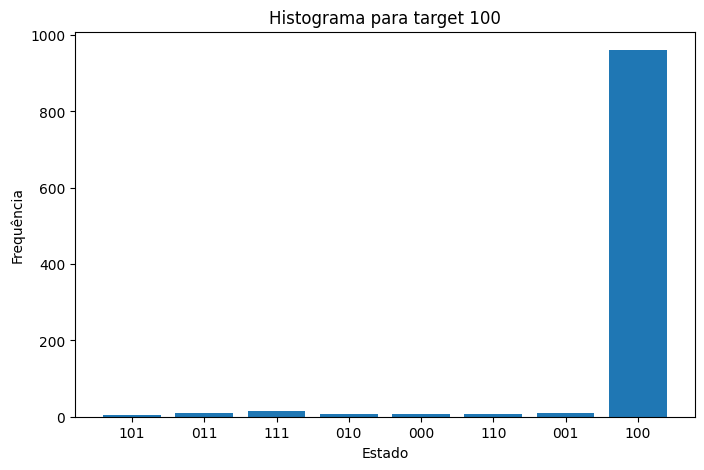

2
Resultados: {'111': 5, '011': 7, '110': 15, '001': 12, '100': 10, '010': 955, '000': 11, '101': 9}


<Figure size 640x480 with 0 Axes>

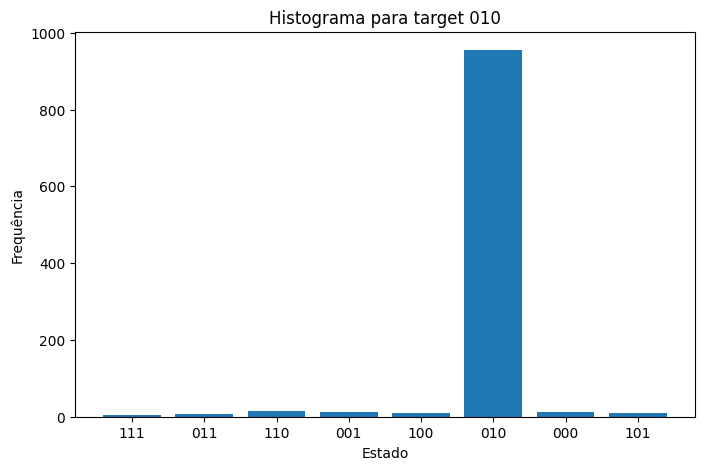

2
Resultados: {'101': 5, '110': 6, '001': 966, '100': 8, '111': 12, '011': 6, '010': 12, '000': 9}


<Figure size 640x480 with 0 Axes>

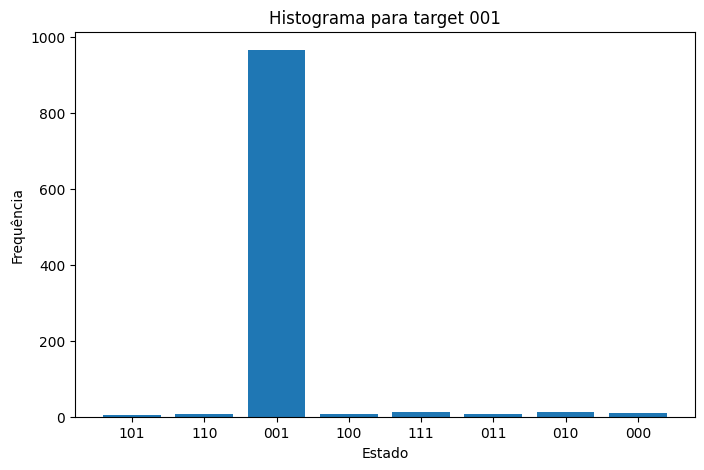

2
Resultados: {'011': 7, '111': 6, '000': 12, '010': 11, '101': 10, '100': 6, '001': 4, '110': 968}


<Figure size 640x480 with 0 Axes>

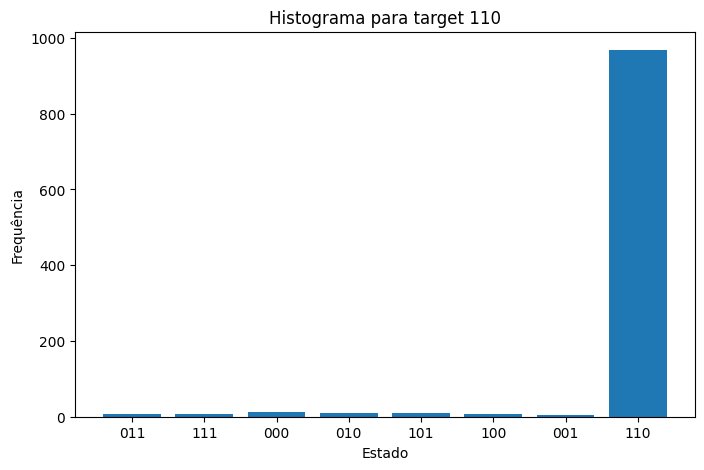

<Figure size 640x480 with 0 Axes>

In [46]:
targets_states = ["100","010","001","110"]
for target_state in targets_states:

    num_qubits = len(target_state)
    qc = QuantumCircuit(num_qubits, num_qubits)

    iterations = math.ceil((math.pi / 4) * math.sqrt(num_qubits))
    print(iterations)

    qc.h(range(num_qubits))

    for _ in range(iterations):
        
        qc.compose(create_grover_oracle(target_state),inplace=True)

        qc.compose(difusion(num_qubits),inplace=True)

    qc.draw('mpl')

    qc.measure(range(num_qubits), range(num_qubits))

    backend = AerSimulator()
    t_qc = transpile(qc, backend)
    result = backend.run(t_qc, shots=1024).result()
    counts = result.get_counts()

    print("Resultados:", counts)

    plot_counts_matplotlib(counts, target_state)


## <b>4 <span style='color:#2ae4f5'>|</span> Simulação com Ruído</b>

### Experimentos iniciais com Ruídos

#### Entendendo a Despolarização

Estado ideal |0>: [0.+0.j 1.+0.j]

Contagens com despolarização p=0.3: {'1': 853, '0': 147}


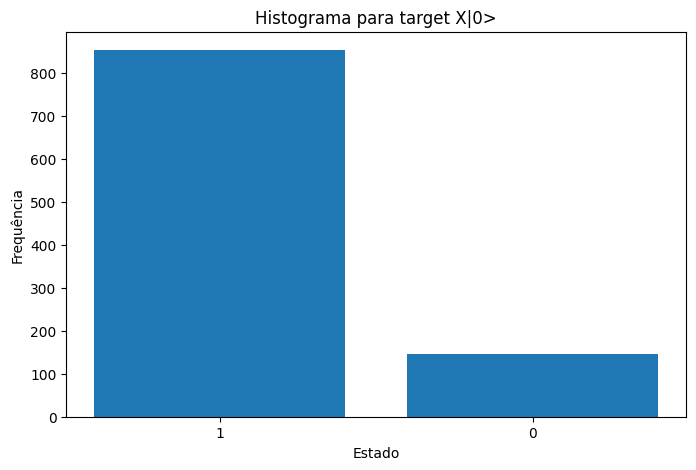

<Figure size 640x480 with 0 Axes>

In [ ]:
qc = QuantumCircuit(1,1)
qc.x(0)  
qc.measure(0,0)

sv_ideal = Statevector.from_instruction(qc.remove_final_measurements(inplace=False))
print("Estado ideal |0>:", sv_ideal.data)

error = depolarizing_error(0.3, 1)
noise_model_i = NoiseModel()
noise_model_i.add_all_qubit_quantum_error(error, ['x'])

backend_noisy = AerSimulator(noise_model=noise_model_i)

t_qc_noisy = transpile(qc, backend_noisy)
result_noisy = backend_noisy.run(t_qc_noisy, shots=1000).result()
counts_noisy = result_noisy.get_counts()

print("\nContagens com despolarização p=0.3:", counts_noisy)
plot_counts_matplotlib(counts_noisy, "X|0>")

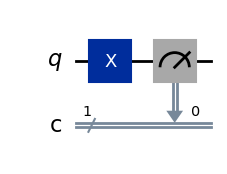

In [4]:
qc.draw('mpl')

Estado ideal |0>: [0.+0.j 1.+0.j]

Contagens sem despolarização: {'1': 1000}


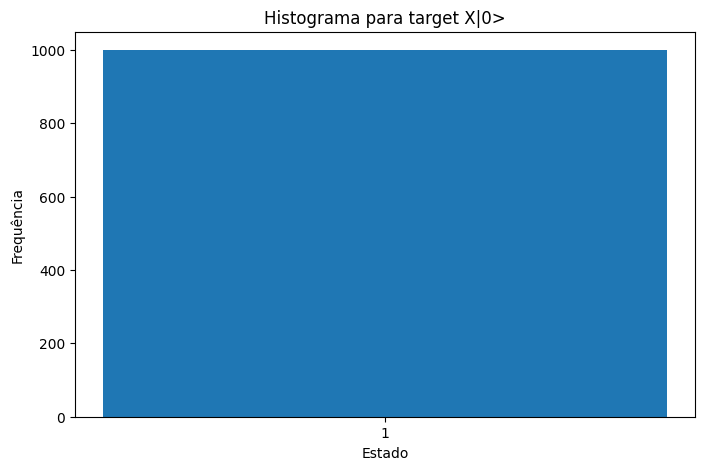

<Figure size 640x480 with 0 Axes>

In [8]:
qc = QuantumCircuit(1,1)
qc.x(0)  
qc.measure(0,0)

sv_ideal = Statevector.from_instruction(qc.remove_final_measurements(inplace=False))
print("Estado ideal |0>:", sv_ideal.data)

backend_ideal = AerSimulator()

t_qc = transpile(qc, backend_ideal)
result = backend_ideal.run(t_qc, shots=1000).result()
counts = result.get_counts()

print("\nContagens sem despolarização:", counts)
plot_counts_matplotlib(counts, "X|0>")

#### Entendendo a Perda de fase e Amplitude

##### Perda de Fase

Contagens com phase damping p=0.3:


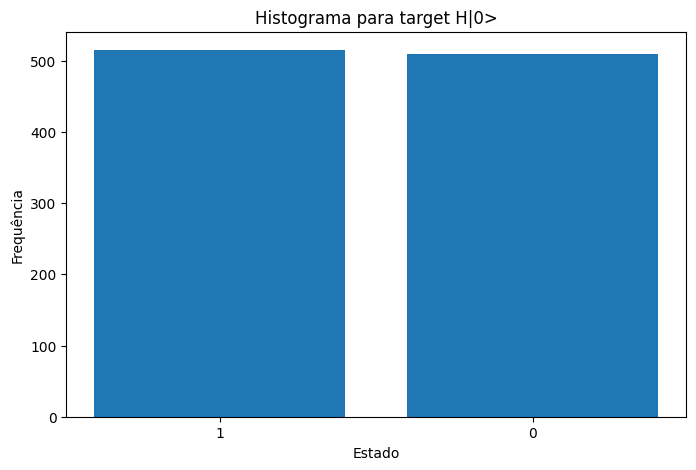

<Figure size 640x480 with 0 Axes>

In [21]:
qc = QuantumCircuit(1,1)
qc.h(0)
qc.measure(0,0)

error = phase_damping_error(0.3)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, ['h'])

backend = AerSimulator(noise_model=noise_model)

t_qc = transpile(qc, backend)
result = backend.run(t_qc, shots=1024).result()
counts = result.get_counts()

print("Contagens com phase damping p=0.3:")
plot_counts_matplotlib(counts, "H|0>")

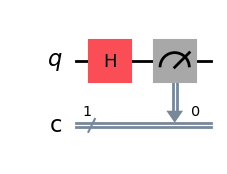

In [22]:
qc.draw('mpl')

##### Perda de Amplitude

Contagens com amplitude damping p=0.3:


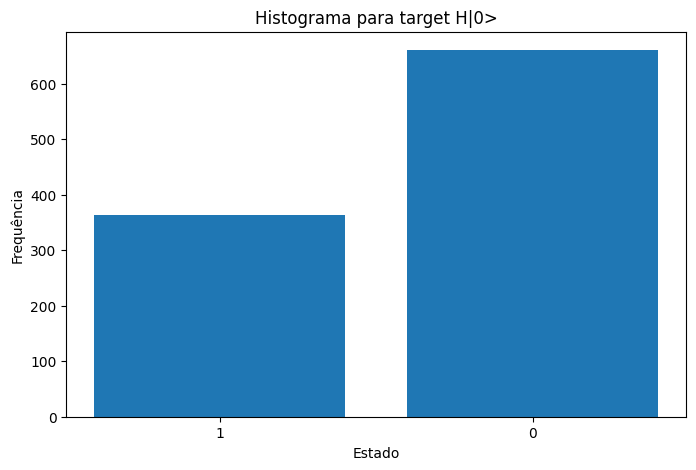

<Figure size 640x480 with 0 Axes>

In [11]:
qc = QuantumCircuit(1,1)
qc.h(0)
qc.measure(0,0)

error = amplitude_damping_error(0.3)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, ['h'])

backend = AerSimulator(noise_model=noise_model)


t_qc = transpile(qc, backend)
result = backend.run(t_qc, shots=1024).result()
counts_amp = result.get_counts()


print("Contagens com amplitude damping p=0.3:")
plot_counts_matplotlib(counts_amp, "H|0>")

### Experimentos com Ruido em Grover

Vamos definir o primeiro modelo de ruído que será utilizado nas simulações.

Erros alocados ao modelo:

* Depolarizing: Um canal de erro de despolarização de n-qubit parametrizado por uma probabilidade de despolarização p.
* Phase Amplitude damping: Um canal de erro de amortecimento de amplitude e fase combinada generalizada de um único qubit dado por um parâmetro de amortecimento de amplitude λ, um parâmetro de amortecimento de fase γ e uma população térmica de estado excitado P1


In [39]:
def noise_model(prob_1q=0.005, prob_2q=0.01, prob_meas=0.01):
    
    noise_model = NoiseModel()


    dep_error_1q = depolarizing_error(prob_1q, 1)
    dep_error_2q = depolarizing_error(prob_2q, 2)
    damping_error = phase_amplitude_damping_error(prob_meas, prob_meas)

    noise_model.add_all_qubit_quantum_error(dep_error_1q, ['h', 'x'])
    noise_model.add_all_qubit_quantum_error(dep_error_2q, ['cx'])
    noise_model.add_all_qubit_quantum_error(damping_error, ['measure'])
    
    return noise_model

2
Resultados: {'011': 73, '111': 83, '101': 126, '001': 82, '100': 340, '110': 107, '000': 121, '010': 92}


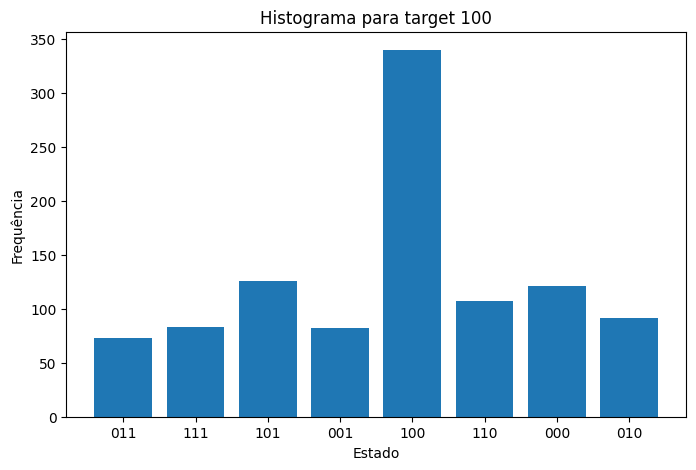

<Figure size 640x480 with 0 Axes>

In [40]:
targets_states = ["100"]
for target_state in targets_states:

    num_qubits = len(target_state)
    qc = QuantumCircuit(num_qubits, num_qubits)

    iterations = math.ceil((math.pi / 4) * math.sqrt(num_qubits))
    print(iterations)

    qc.h(range(num_qubits))

    for _ in range(iterations):
        
        qc.compose(create_grover_oracle(target_state),inplace=True)

        qc.compose(difusion(num_qubits),inplace=True)

    qc.draw('mpl')

    qc.measure(range(num_qubits), range(num_qubits))

    backend_noisy = AerSimulator(noise_model=noise_model(prob_1q=0.02, prob_2q=0.04, prob_meas=0.02))

    t_qc_noisy = transpile(qc, backend_noisy)
    result_noisy = backend_noisy.run(t_qc_noisy, shots=1024).result()
    counts_noisy = result_noisy.get_counts()

    print("Resultados:", counts_noisy)

    plot_counts_matplotlib(counts_noisy, target_state)


Extraindo o modelo de ruido de backends reais

In [4]:
print("Backends disponíveis:")
for backend in service.backends():
    print("-", backend)
    noise_model = NoiseModel.from_backend(backend)

    print(noise_model)

qiskit_runtime_service.backends:WARNING:2025-11-20 15:22:25,889: Loading instance: Projeto-Algo_I, plan: open


Backends disponíveis:
- <IBMBackend('ibm_fez')>
NoiseModel:
  Basis gates: ['cz', 'delay', 'id', 'if_else', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['cz', 'x', 'measure', 'reset', 'sx', 'id']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
  Specific qubit errors: [('cz', (0, 1)), ('cz', (1, 0)), ('cz', (1, 2)), ('cz', (2, 1)), ('

2
Resultados: {'010': 4, '000': 13, '101': 17, '011': 15, '111': 12, '110': 20, '001': 14, '100': 929}


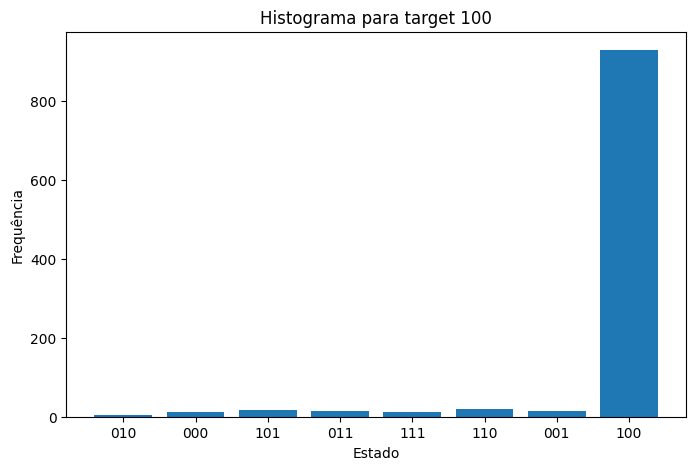

<Figure size 640x480 with 0 Axes>

In [40]:
targets_states = ["100"]
for target_state in targets_states:

    num_qubits = len(target_state)
    qc = QuantumCircuit(num_qubits, num_qubits)

    iterations = math.ceil((math.pi / 4) * math.sqrt(num_qubits))
    print(iterations)

    qc.h(range(num_qubits))

    for _ in range(iterations):
        
        qc.compose(create_grover_oracle(target_state),inplace=True)

        qc.compose(difusion(num_qubits),inplace=True)

    qc.draw('mpl')

    qc.measure(range(num_qubits), range(num_qubits))

    backend_noisy = AerSimulator(noise_model=noise_model)

    t_qc_noisy = transpile(qc, backend_noisy)
    result_noisy = backend_noisy.run(t_qc_noisy, shots=1024).result()
    counts_noisy = result_noisy.get_counts()

    print("Resultados:", counts_noisy)

    plot_counts_matplotlib(counts_noisy, target_state)
